# Test Notebook to play with and learn the API

In [1]:
import os
from datetime import datetime

fabric_refresh_token = None
%store -r fabric_refresh_token
if fabric_refresh_token is None:
    fabric_refresh_token=os.environ['CILOGON_REFRESH_TOKEN']
    %store fabric_refresh_token
    
print("Refresh Token: {}".format(fabric_refresh_token))
now = datetime.now()
print("Refresh Token Issued at {}".format(now))
print(os.environ['CILOGON_REFRESH_TOKEN'])

no stored variable or alias fabric_refresh_token
Stored 'fabric_refresh_token' (str)
Refresh Token: NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTKOLEMM3DIYZWGQZWGNDEHBRTKMLFMM4DKNBRMY4TOMZXGQYTSNZ7OR4XAZJ5OJSWM4TFONUFI33LMVXCM5DTHUYTMMRSGM3TINBRHAYDQMBGOZSXE43JN5XD25RSFYYCM3DJMZSXI2LNMU6TQNRUGAYDAMBQ
Refresh Token Issued at 2021-05-30 15:37:21.856739
NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTKOLEMM3DIYZWGQZWGNDEHBRTKMLFMM4DKNBRMY4TOMZXGQYTSNZ7OR4XAZJ5OJSWM4TFONUFI33LMVXCM5DTHUYTMMRSGM3TINBRHAYDQMBGOZSXE43JN5XD25RSFYYCM3DJMZSXI2LNMU6TQNRUGAYDAMBQ


In [2]:
import os
import json

from fabrictestbed.slice_manager import SliceManager, Status

credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")
      
# Create Slice Manager
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, 
                             refresh_token=fabric_refresh_token, project_name='all', scope='all')

#Configure SSH Key
ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read().strip()
    
#print(ssh_key)

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net


In [5]:
try:
    id_token, refresh_token = slice_manager.refresh_tokens()
except Exception as e:
    print("Exception occured while getting tokens:{}".format(e))
    
fabric_refresh_token=slice_manager.get_refresh_token()
fabric_id_token=slice_manager.get_id_token()

print()
print("New Refresh Token: {}".format(fabric_refresh_token))
print("New ID Token: {}".format(fabric_id_token))
print()
print("Stored new Refresh Token")
%store fabric_refresh_token
print()



New Refresh Token: NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTGZTEGY3DAYRQGI2DKOBYGU2DEOBSMYYTKYRSGIYTAZRQHAZTINB7OR4XAZJ5OJSWM4TFONUFI33LMVXCM5DTHUYTMMRSGM4TIMBQGY2DENRGOZSXE43JN5XD25RSFYYCM3DJMZSXI2LNMU6TQNRUGAYDAMBQ
New ID Token: eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6ImI0MTUxNjcyMTExOTFlMmUwNWIyMmI1NGIxZDNiNzY2N2U3NjRhNzQ3NzIyMTg1ZTcyMmU1MmUxNDZmZTQzYWEifQ.eyJlbWFpbCI6ImxvY2tlakBidS5lZHUiLCJjZXJ0X3N1YmplY3RfZG4iOiIvREM9b3JnL0RDPWNpbG9nb24vQz1VUy9PPUJvc3RvbiBVbml2ZXJzaXR5L0NOPUpvc2VwaCBSeWFuIExvY2tlIEI0NjEzMTg5NyIsImlkcCI6Imh0dHBzOi8vc2hpYi5idS5lZHUvaWRwL3NoaWJib2xldGgiLCJpZHBfbmFtZSI6IkJvc3RvbiBVbml2ZXJzaXR5IiwiZXBwbiI6ImxvY2tlakBidS5lZHUiLCJlcHRpZCI6Imh0dHBzOi8vc2hpYi5idS5lZHUvaWRwL3NoaWJib2xldGghaHR0cHM6Ly9jaWxvZ29uLm9yZy9zaGliYm9sZXRoITh0QSszdTRNYitoMGNMbEV0a1JIVXNUOHBYQT0iLCJhZmZpbGlhdGlvbiI6InN0dWRlbnRAYnUuZWR1O21lbWJlckBidS5lZHUiLCJuYW1lIjoiSm9zZXBoIFJ5YW4gTG9ja2UiLCJhY3IiOiJodHRwczovL3NoaWIuYnUuZWR1L3NpbmdsZSIsImVudGl0bGVtZW50IjoiaHR0cDovL2lhbS5idS5lZHUvcmVnL2NvbGxlZ2

In [15]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
print(f"Topology: {advertised_topology}")
#advertised_topology.draw()

Status: Status.FAILURE
Topology: (504)
Reason: Gateway Time-out
HTTP response headers: HTTPHeaderDict({'Server': 'nginx/1.19.8', 'Date': 'Sun, 30 May 2021 17:35:33 GMT', 'Content-Type': 'text/html', 'Content-Length': '167', 'Connection': 'keep-alive'})
HTTP response body: <html>
<head><title>504 Gateway Time-out</title></head>
<body>
<center><h1>504 Gateway Time-out</h1></center>
<hr><center>nginx/1.19.8</center>
</body>
</html>




### Slice Request

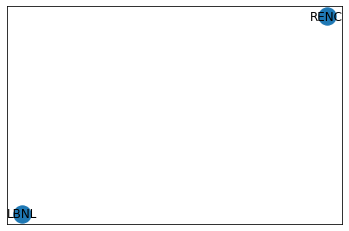

In [13]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, LinkType, Layer

experiment = ExperimentTopology()

slice_name="JacksTestSlice2"

node1 = experiment.add_node(name='RENC', site='RENC')

node1_capacity = Capacities()
node1_capacity.set_fields(core=2, ram=32, disk=256)
node1.set_properties(capacities=node1_capacity, image_type='qcow2', image_ref='default_ubuntu_20')

node1_nvme = node1.add_component(ctype=ComponentType.NVME, model='P4510', name='n1_nvme')
node1_gpu = node1.add_component(ctype=ComponentType.GPU, model='Tesla T4', name='n1_gpu')
node1_nic = node1.add_component(ctype=ComponentType.SharedNIC, model='ConnectX-6', name='n1_nic')

node2 = experiment.add_node(name='LBNL', site='LBNL')

node2_capacity = Capacities()
node2_capacity.set_fields(core=2, ram=16, disk=256)
node2.set_properties(capacities=node2_capacity, image_type='qcow2', image_ref='default_ubuntu_20')

node2_nvme = node2.add_component(ctype=ComponentType.NVME, model='P4510', name='n2_nvme')
node2_gpu = node2.add_component(ctype=ComponentType.GPU, model='Tesla T4', name='n2_gpu')
node2_nic = node2.add_component(ctype=ComponentType.SharedNIC, model='ConnectX-6', name='n2_nic')

experiment.draw()

In [14]:
slice_graph = experiment.serialize()

status, reservations = slice_manager.create(slice_name=slice_name, slice_graph=slice_graph, ssh_key=ssh_key)
#print(status)
#print(reservations)
print("Request {}".format(status))
slice_id=reservations[0].slice_id

print("Reservations: {}".format(reservations))
print("Slice ID: {}".format(slice_id))

Request Status.FAILURE


TypeError: 'ApiException' object is not subscriptable

In [ ]:
import time

slice_state=None
while slice_state != 'StableOK':
    status, slice_status = slice_manager.slice_status(slice_id=slice_id)
    slice_state = slice_status.slice_state
    print("Response Status {}".format(status))
    print("Slice State: {}".format(slices[0].slice_state))
    time.sleep(20)
    
print("Response Status {}".format(status))
print("Slice Status {}".format(slice_status))

In [ ]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
print("Slivers {}".format(reservations))

In [ ]:
status, result = slice_manager.delete(slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))